In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

First, remove artefacts, center and smoothen the raw GROMACS trajectories using the `trjconv` module.

```bash
gmx trjconv -s md500.tpr -f md500.xtc -n index.ndx -o md500_compact.xtc -center -pbc mol -ur compact
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_compact_compact.xtc -fit rot+trans
```

Dump out the first frame of the trajectory

```bash
gmx trjconv -s md500.tpr -f md500_compact.xtc -n index.ndx -o md500_start.pdb -dump 0
```

In all cases, Choose `Protein` for centering and `Protein_LIG_ZN2` for output. Not selecting the whole system for output removes water and loose ions and compresses the trajectory files.



## RMSD Calculation

In [57]:
#Read all the trajectories
mmp9_rol_01 = mda.Universe('md500_1_start.pdb', 'md500_1_compact_compact.xtc')
mmp9_rol_02 = mda.Universe('md500_2_start.pdb', 'md500_2_compact_compact.xtc')


In [3]:
from MDAnalysis.analysis import rms

R = rms.RMSD(mmp9_rol_01,  # universe to align
    mmp9_rol_01,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c_run1 = R.results.rmsd[:,1]
rmsd_c_run1 = R.results.rmsd[:,2]

  0%|          | 0/50001 [00:00<?, ?it/s]

In [4]:
from MDAnalysis.analysis import rms

R = rms.RMSD(mmp9_rol_02,  # universe to align
    mmp9_rol_02,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c_run2 = R.results.rmsd[:,1]
rmsd_c_run2 = R.results.rmsd[:,2]

  0%|          | 0/50001 [00:00<?, ?it/s]

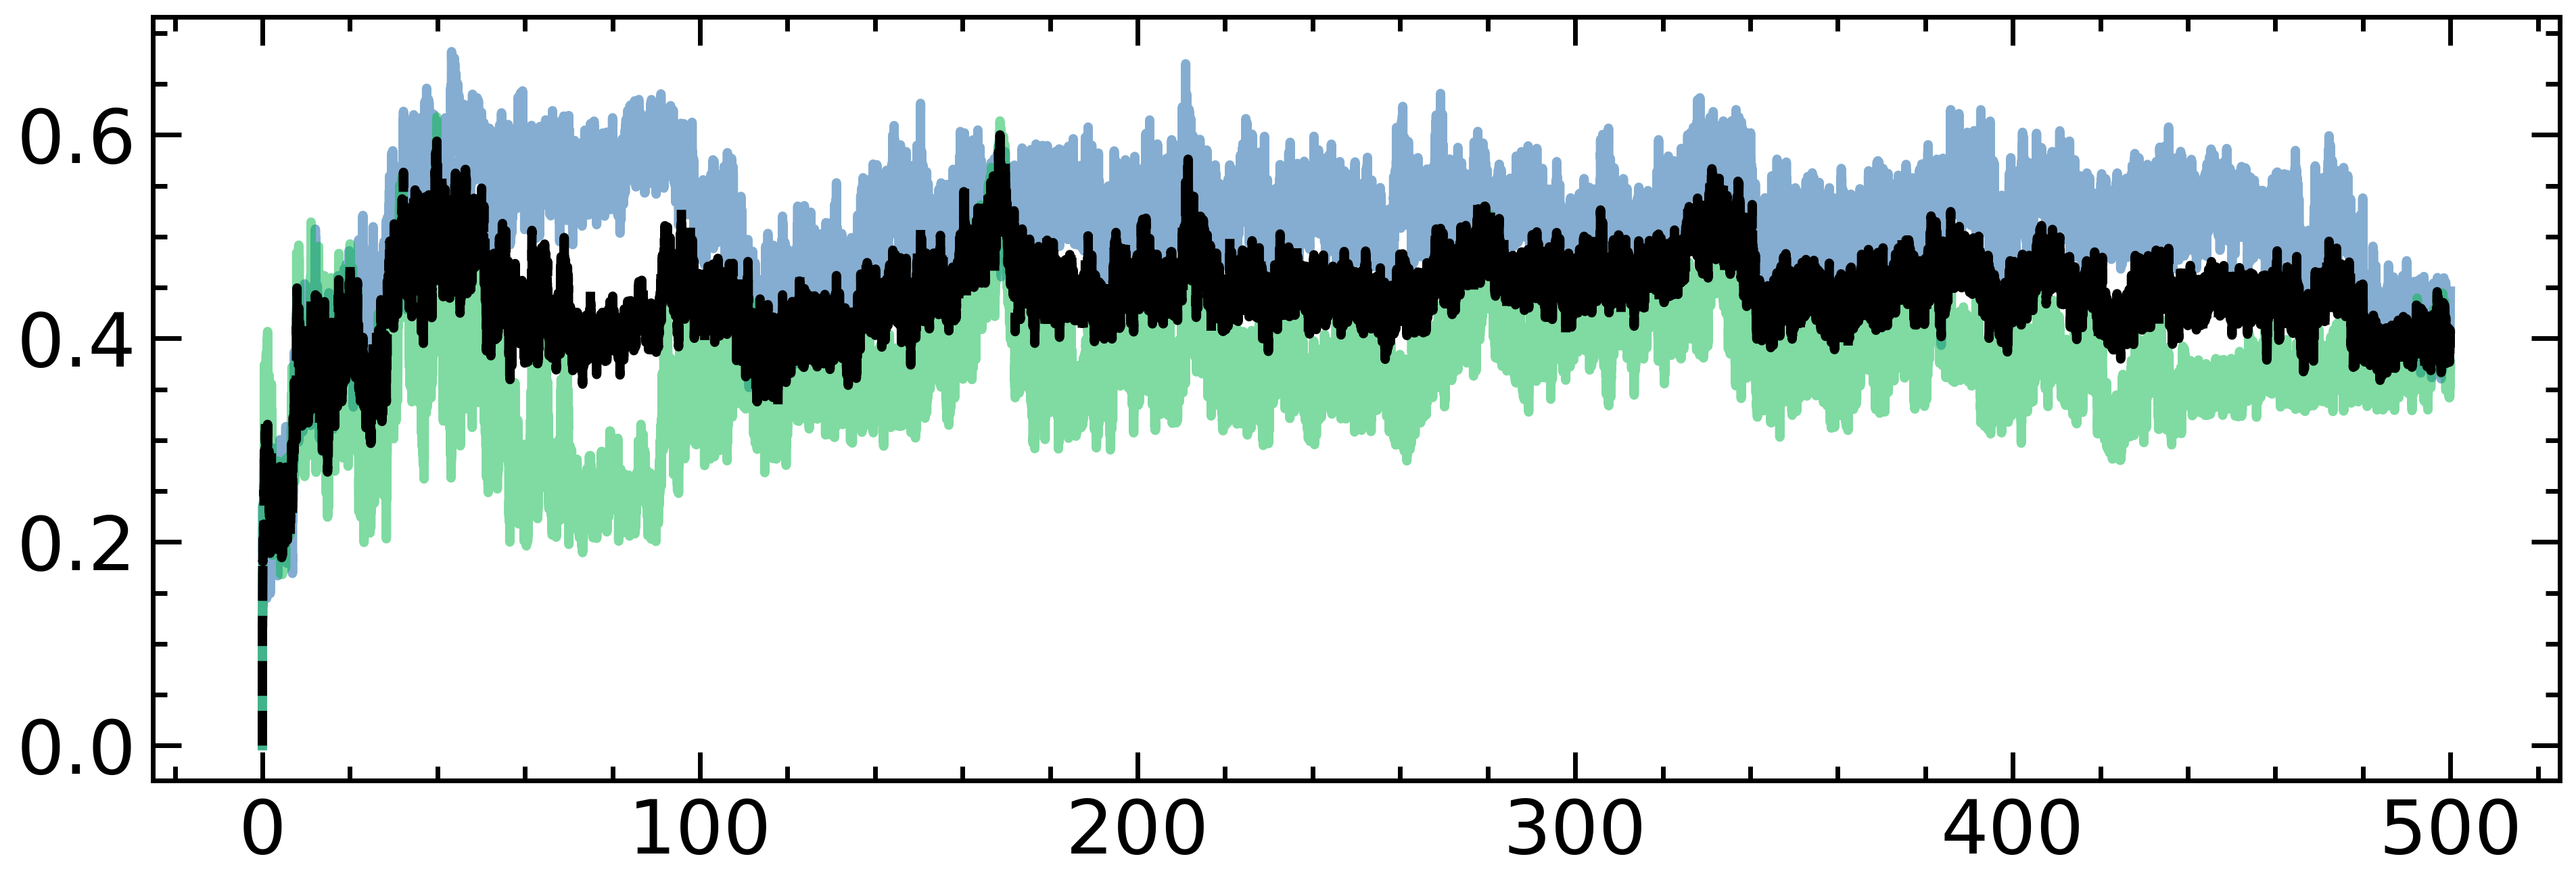

In [5]:
plt.plot(times_c_run1/1000, rmsd_c_run1/10, alpha=0.5)
plt.plot(times_c_run2/1000, rmsd_c_run2/10, alpha=0.5)

times_c = (times_c_run1 + times_c_run2)/2
rmsd_c = (rmsd_c_run1 + rmsd_c_run2)/2

plt.plot(times_c/1000, rmsd_c/10, 'k--')
fig = plt.gcf()
fig.set_figheight(fig.get_figheight() / 2)


## Radius of Gyration Calculation

In [6]:
from tqdm.notebook import tqdm
group = mmp9_rol_01.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(mmp9_rol_01.trajectory):
	Frame.append(ts.frame)
	times.append(mmp9_rol_01.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_run1_table = np.vstack((Frame, times, Rgyr)).T

  0%|          | 0/50001 [00:00<?, ?it/s]

In [7]:
from tqdm.notebook import tqdm
group = mmp9_rol_02.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(mmp9_rol_02.trajectory):
	Frame.append(ts.frame)
	times.append(mmp9_rol_02.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_run2_table = np.vstack((Frame, times, Rgyr)).T

  0%|          | 0/50001 [00:00<?, ?it/s]

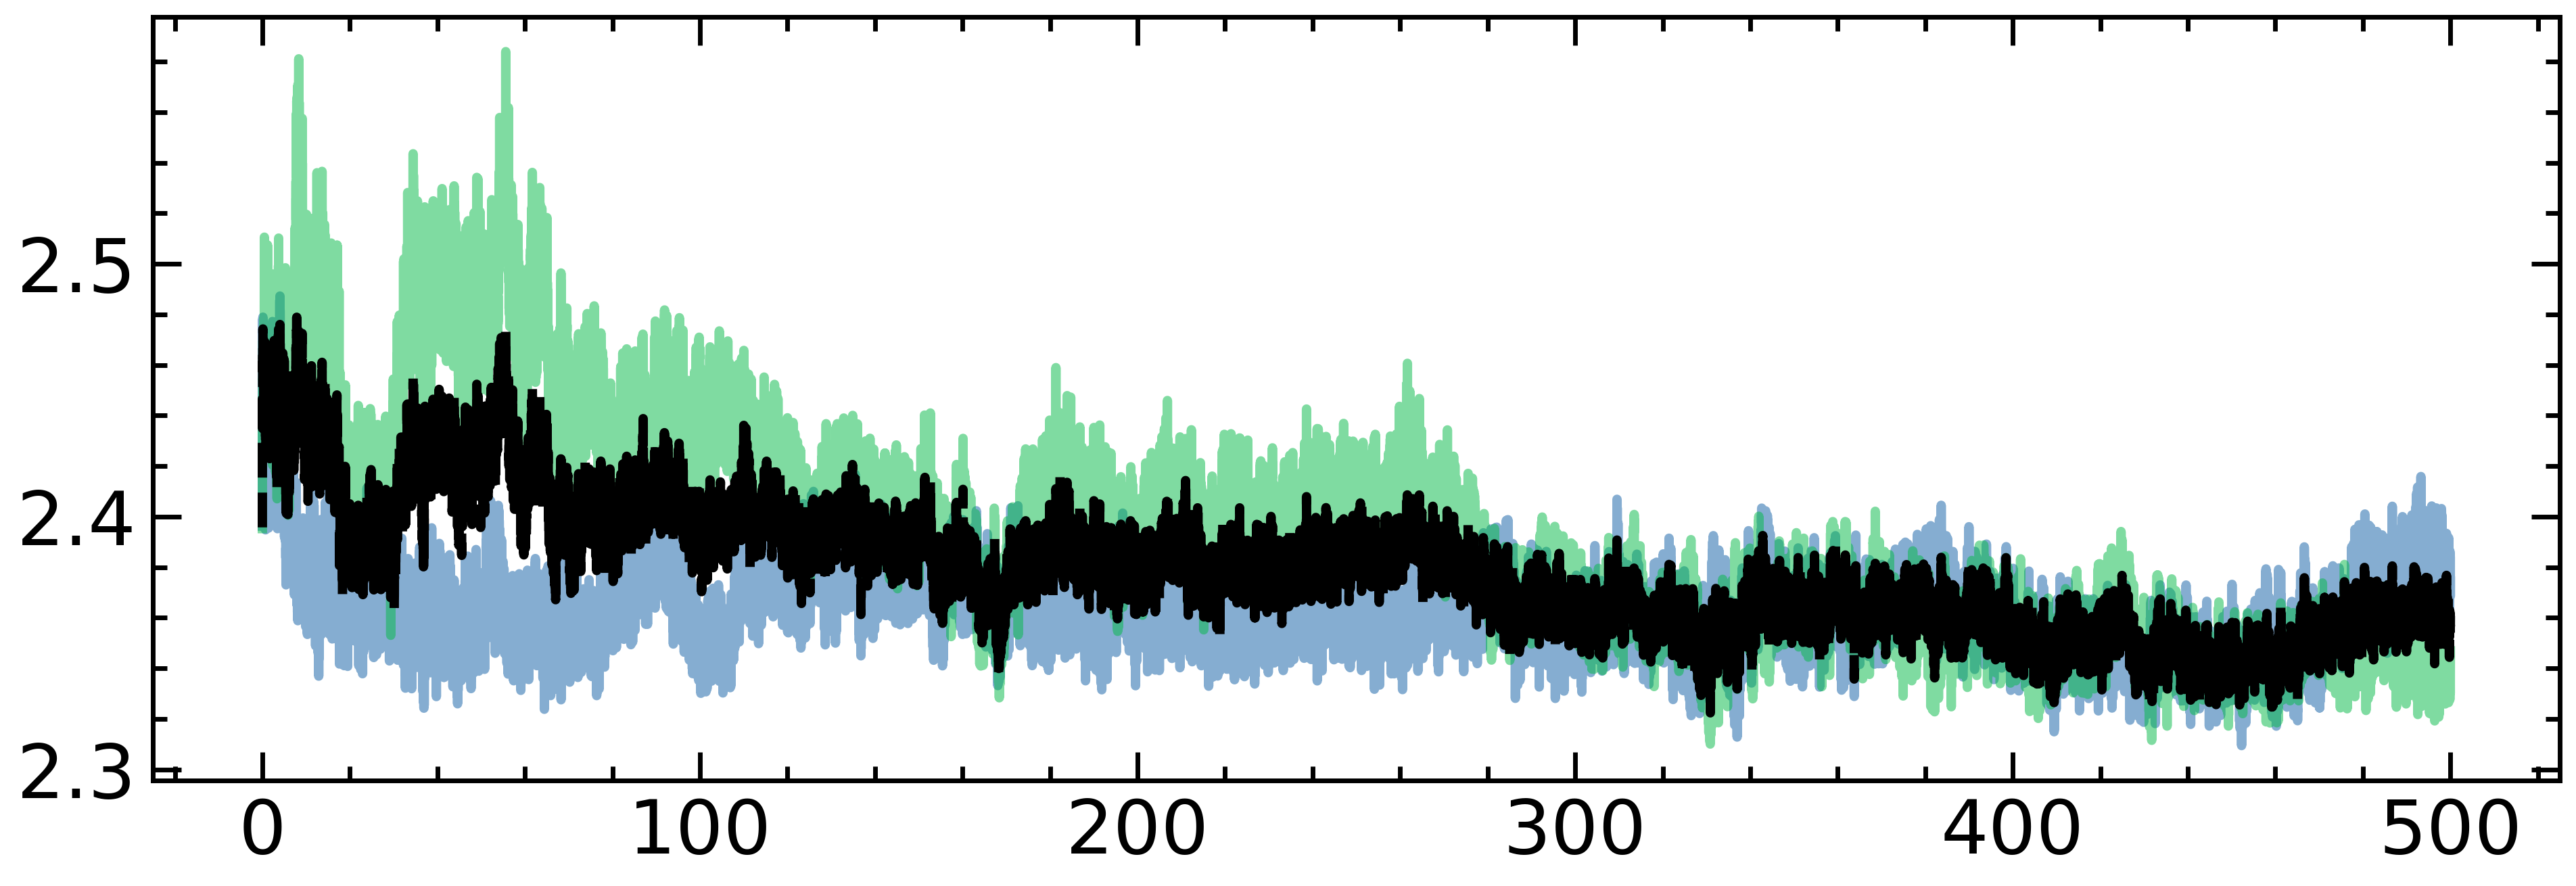

In [8]:
plt.plot(Rgyrc_run1_table[:,1]/1000, Rgyrc_run1_table[:,2]/10, alpha=0.5)
plt.plot(Rgyrc_run2_table[:,1]/1000, Rgyrc_run2_table[:,2]/10, alpha=0.5)

Rgyrc_table = (Rgyrc_run1_table + Rgyrc_run2_table)/2
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10,'k--')

fig = plt.gcf()
fig.set_figheight(fig.get_figheight() / 2)

## RMSF Calculation

Between protein backbone and Carbon alphas.

In [9]:
c_alphas_c_run1 = mmp9_rol_01.select_atoms('backbone and name CA')
R_c_run1 = rms.RMSF(c_alphas_c_run1).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [10]:
c_alphas_c_run2 = mmp9_rol_02.select_atoms('backbone and name CA')
R_c_run2 = rms.RMSF(c_alphas_c_run2).run(verbose=True)

  0%|          | 0/50001 [00:00<?, ?it/s]

In [11]:
c_alphas_c_resids = (c_alphas_c_run1.resids + c_alphas_c_run2.resids)/2
R_c_results_rmsf = (R_c_run1.results.rmsf + R_c_run2.results.rmsf)/2

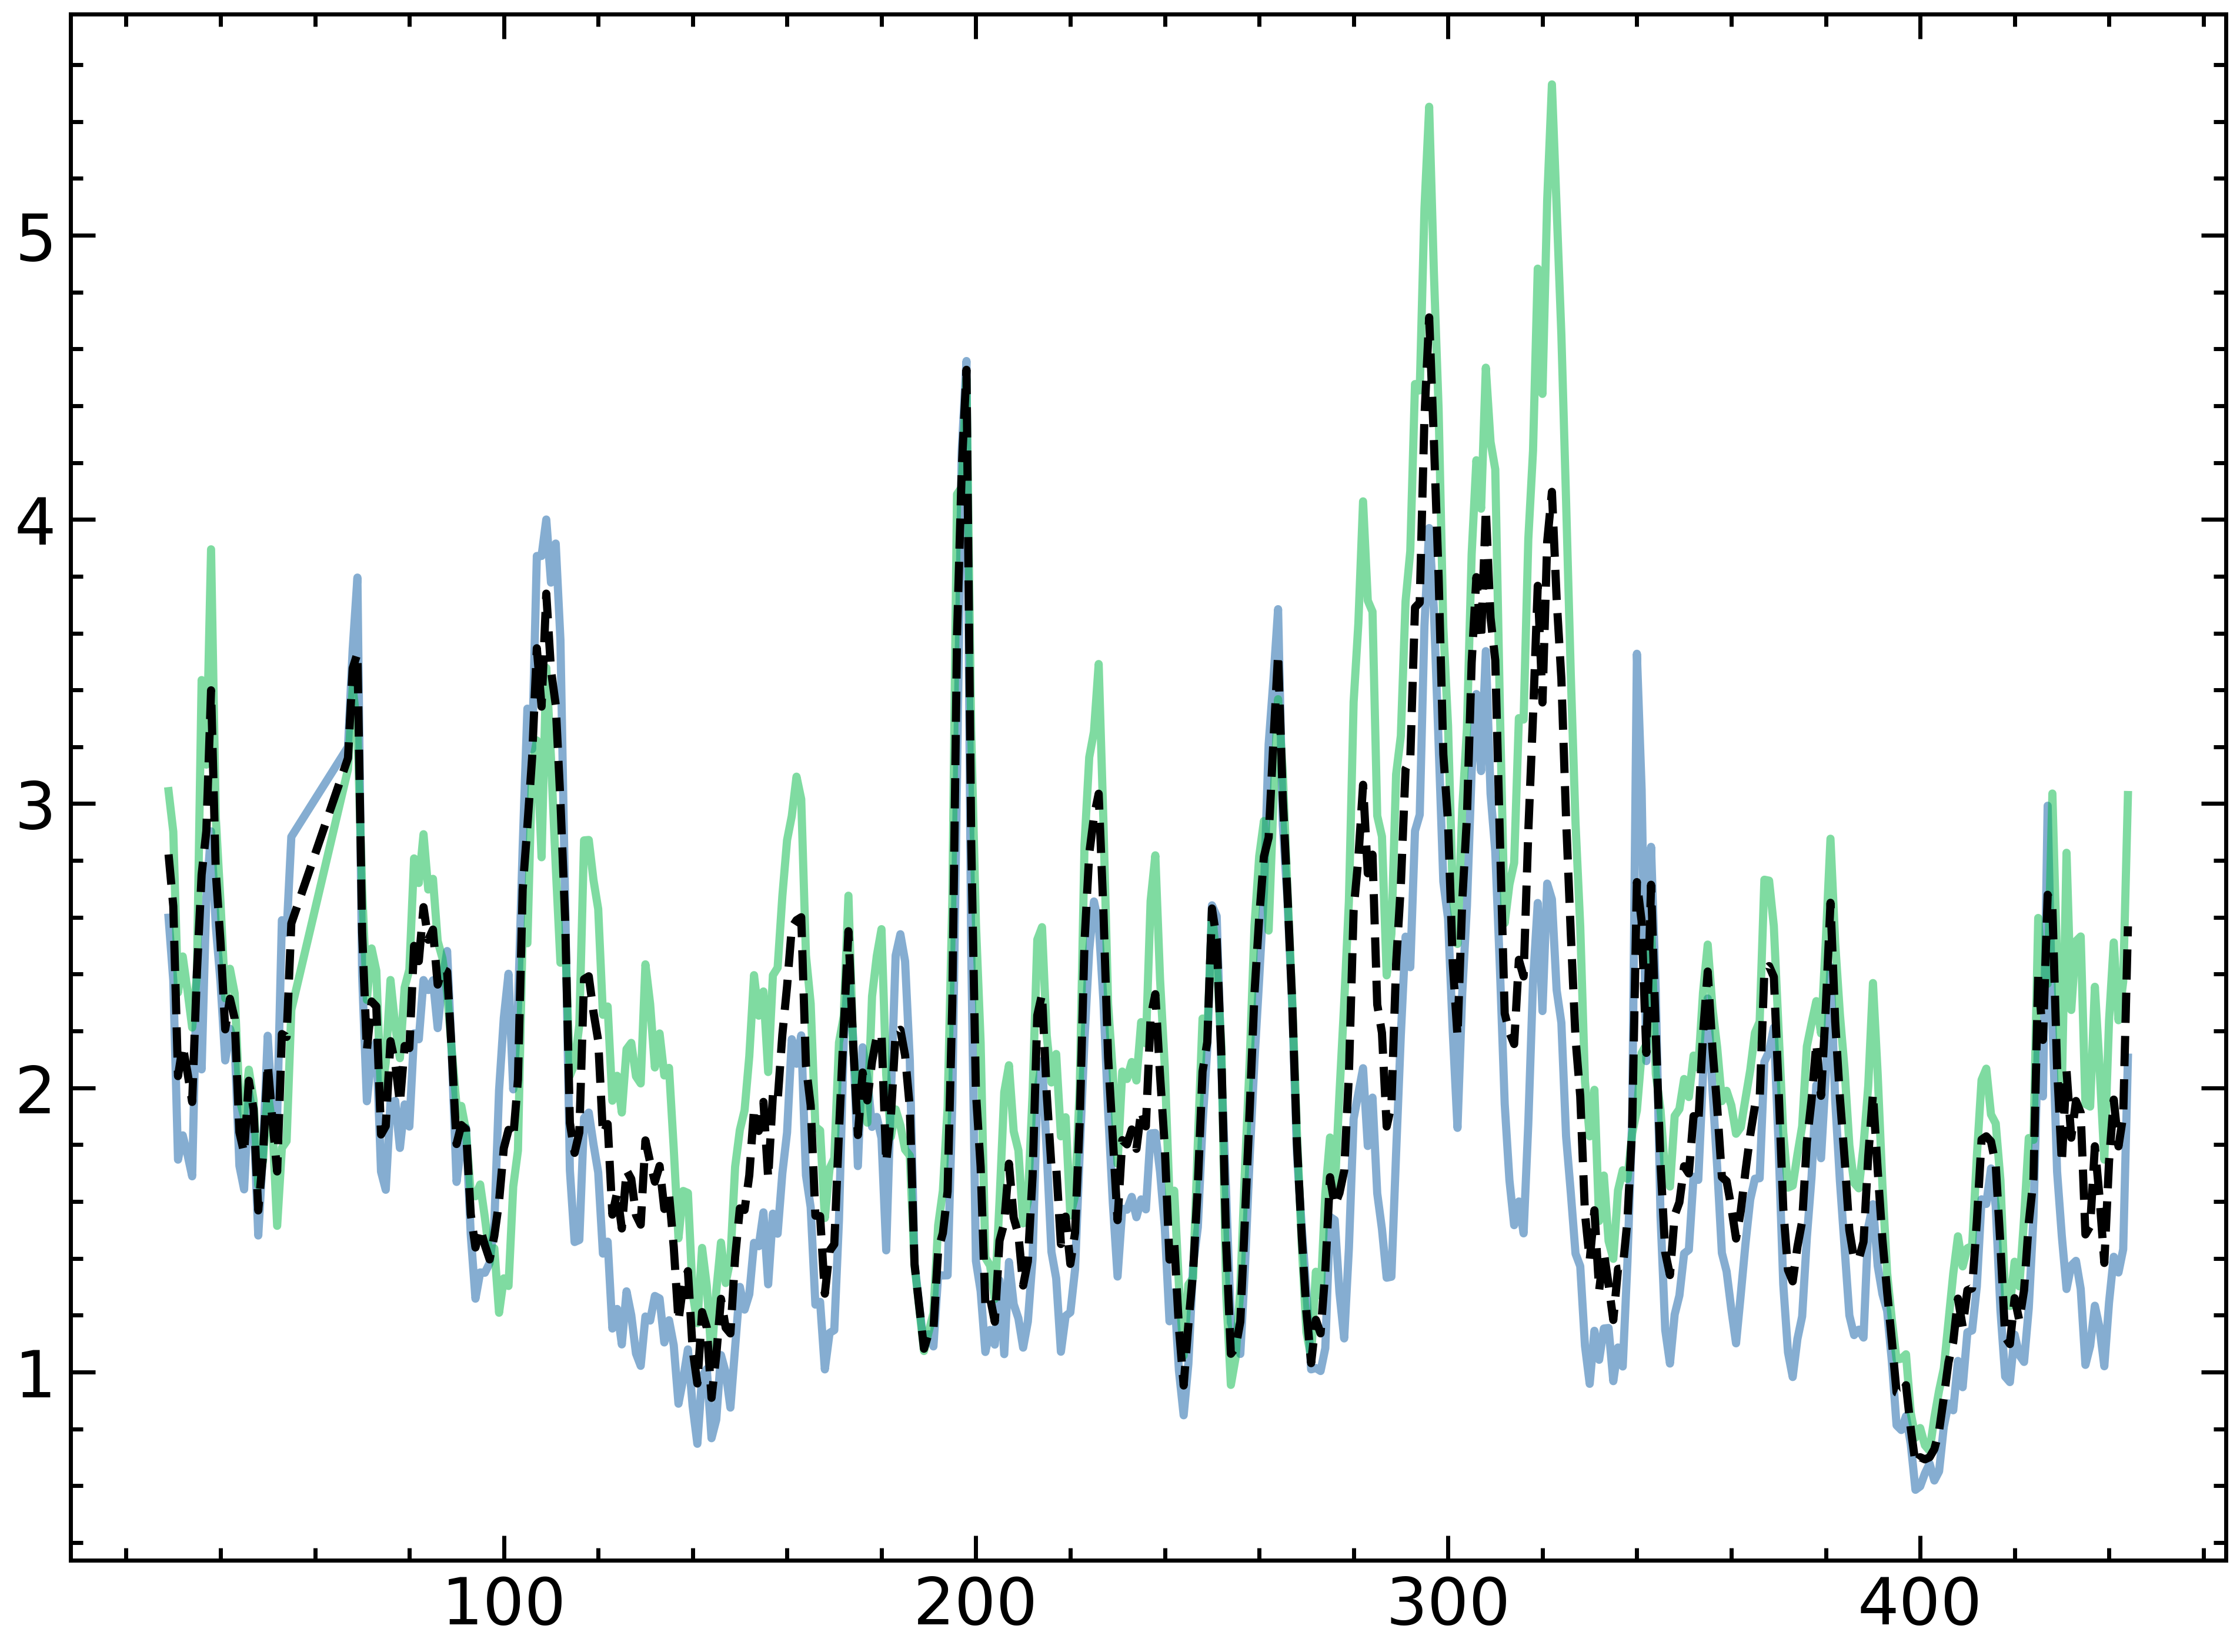

In [12]:
plt.plot(c_alphas_c_run1.resids, R_c_run1.results.rmsf, alpha=0.5)
plt.plot(c_alphas_c_run2.resids, R_c_run2.results.rmsf, alpha=0.5)
plt.plot(c_alphas_c_resids, R_c_results_rmsf, 'k--')

## H-bond analysis:

**Note:** As of today (20241222), the latest version of MDAnalysis (2.8) cannot read binary topology files (the ones with the `.tpr` extension) created by gromacs version 2024.4. Binary topology data is necessary for hydrogen bond analysis in `MDAnalysis` for some reason, so I am trying `MDTraj` instead.


In `MDTraj`, the Baker-Hubbard Hydrogen Bond Identification can be used, where the hydrogen bond is said to have formed if:

1. The angle $\theta_{dha}>2\pi/3$, *i.e.*, $120$ degrees, and
2. The distance $r_{ha}<0.25\;nm$. 
   
Here, $d$ means 'donor', 'h' means 'hydrogen', and 'a' means acceptor.
The donors considered by this method are NH and OH, and the acceptors considered are O and N.

Do not load the whole trajectory, as it will take up too much memory. Unlike `MDAnalysis`, `MDTraj` doesn't do lazy loads from disk, but fully operates in memory. This makes it faster, but memory-intensive.

So, we choose a 'stride' of, say, $60$ frames, and have `MDTraj` load every $60^{th}$ frame of the trajectory, then run the baker-hubbard algorithm.

In [31]:
stride = 60
total_frames = 50000
total_time_ns = 500

timestep  = (stride/total_frames) * total_time_ns

nframes = int(np.ceil(total_frames/stride))

timestep, nframes

(0.6, 834)

In [32]:
%%time
import numpy as np
import mdtraj as md


xtcfile='md500_1_compact_compact.xtc'
topfile='md500_1_start.pdb'

full_traj_run1 = md.load_xtc(xtcfile, stride=stride, top=topfile)
rol_atoms = full_traj_run1.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj_run1, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj_run1.topology.atom(hbond[0]),\
                                            full_traj_run1.topology.atom(hbond[1]),\
                                            full_traj_run1.topology.atom(hbond[2]))
rol_hbonds_run1 = []
for hbond in hbonds:
    d,h,a = hbond
    if d in rol_atoms or a in rol_atoms:
        rol_hbonds_run1.append(hbond)
        print(label(hbond))

rol_hbonds_run1 = np.array(rol_hbonds_run1)

LEU188-N - LEU188-H ... LIG502-O
ALA189-N - ALA189-H ... LIG502-O
ARG424-N - ARG424-H ... LIG502-O1
ARG424-N - ARG424-H ... LIG502-O2
CPU times: user 24.9 s, sys: 1.01 s, total: 25.9 s
Wall time: 28.5 s


In [53]:
%%time
import numpy as np
import mdtraj as md


xtcfile='md500_2_compact_compact.xtc'
topfile='md500_2_start.pdb'

full_traj_run2 = md.load_xtc(xtcfile, stride=stride, top=topfile)
rol_atoms = full_traj_run1.topology.select('resname LIG')
hbonds = md.baker_hubbard(full_traj_run2, periodic=False, freq=0.01)
label = lambda hbond : '%s - %s ... %s' % ( full_traj_run2.topology.atom(hbond[0]),\
                                            full_traj_run2.topology.atom(hbond[1]),\
                                            full_traj_run2.topology.atom(hbond[2]))
rol_hbonds_run2 = []
for hbond in hbonds:
    d,h,a = hbond
    if d in rol_atoms or a in rol_atoms:
        rol_hbonds_run2.append(hbond)
        print(label(hbond))

rol_hbonds_run2 = np.array(rol_hbonds_run2)

CYS99-N - CYS99-H ... LIG502-O
SER394-N - SER394-H ... LIG502-O
SER394-N - SER394-H ... LIG502-O2
TYR423-N - TYR423-H ... LIG502-O
TYR423-N - TYR423-H ... LIG502-O1
TYR423-N - TYR423-H ... LIG502-O2
ARG424-N - ARG424-H ... LIG502-O1
ARG424-NH1 - ARG424-HH11 ... LIG502-O2
CPU times: user 23.8 s, sys: 1.55 s, total: 25.4 s
Wall time: 27.9 s


So, according to `MDTraj` Baker-Hubbard hbond detector, there are only $2$ hydrogen bonds common to both runs 
at more than a frequency of `freq=` $0.01$ in the trajectory frames. They are

\begin{align*}
ARG424-N &- H\cdots O_1 \\
ARG424-NH_1 &- HH_{11}\cdots O_2
\end{align*}

Calculate the distances and angles for each hbond.

In [34]:
da_distances_run1 = md.compute_distances(full_traj_run1, rol_hbonds_run1[:, [1,2]], periodic=False)
da_angles_run1 = md.compute_angles(full_traj_run1, rol_hbonds_run1, periodic=False)

Let us get the number of hbonds between protein and ligand.

In [19]:
distance_met_run1 = da_distances_run1 < 0.25
angle_met_run1 = da_angles_run1 > 2 * np.pi/3
hbond_met_run1 = np.logical_and(distance_met_run1, angle_met_run1)
num_hbonds_run1 = np.sum(hbond_met_run1, axis=1)

In [54]:
da_distances_run2 = md.compute_distances(full_traj_run2, rol_hbonds_run2[:, [1,2]], periodic=False)
da_angles_run2 = md.compute_angles(full_traj_run2, rol_hbonds_run2, periodic=False)

In [21]:
distance_met_run2 = da_distances_run2 < 0.25
angle_met_run2 = da_angles_run2 > 2 * np.pi/3
hbond_met_run2 = np.logical_and(distance_met_run2, angle_met_run2)
num_hbonds_run2 = np.sum(hbond_met_run2, axis=1)

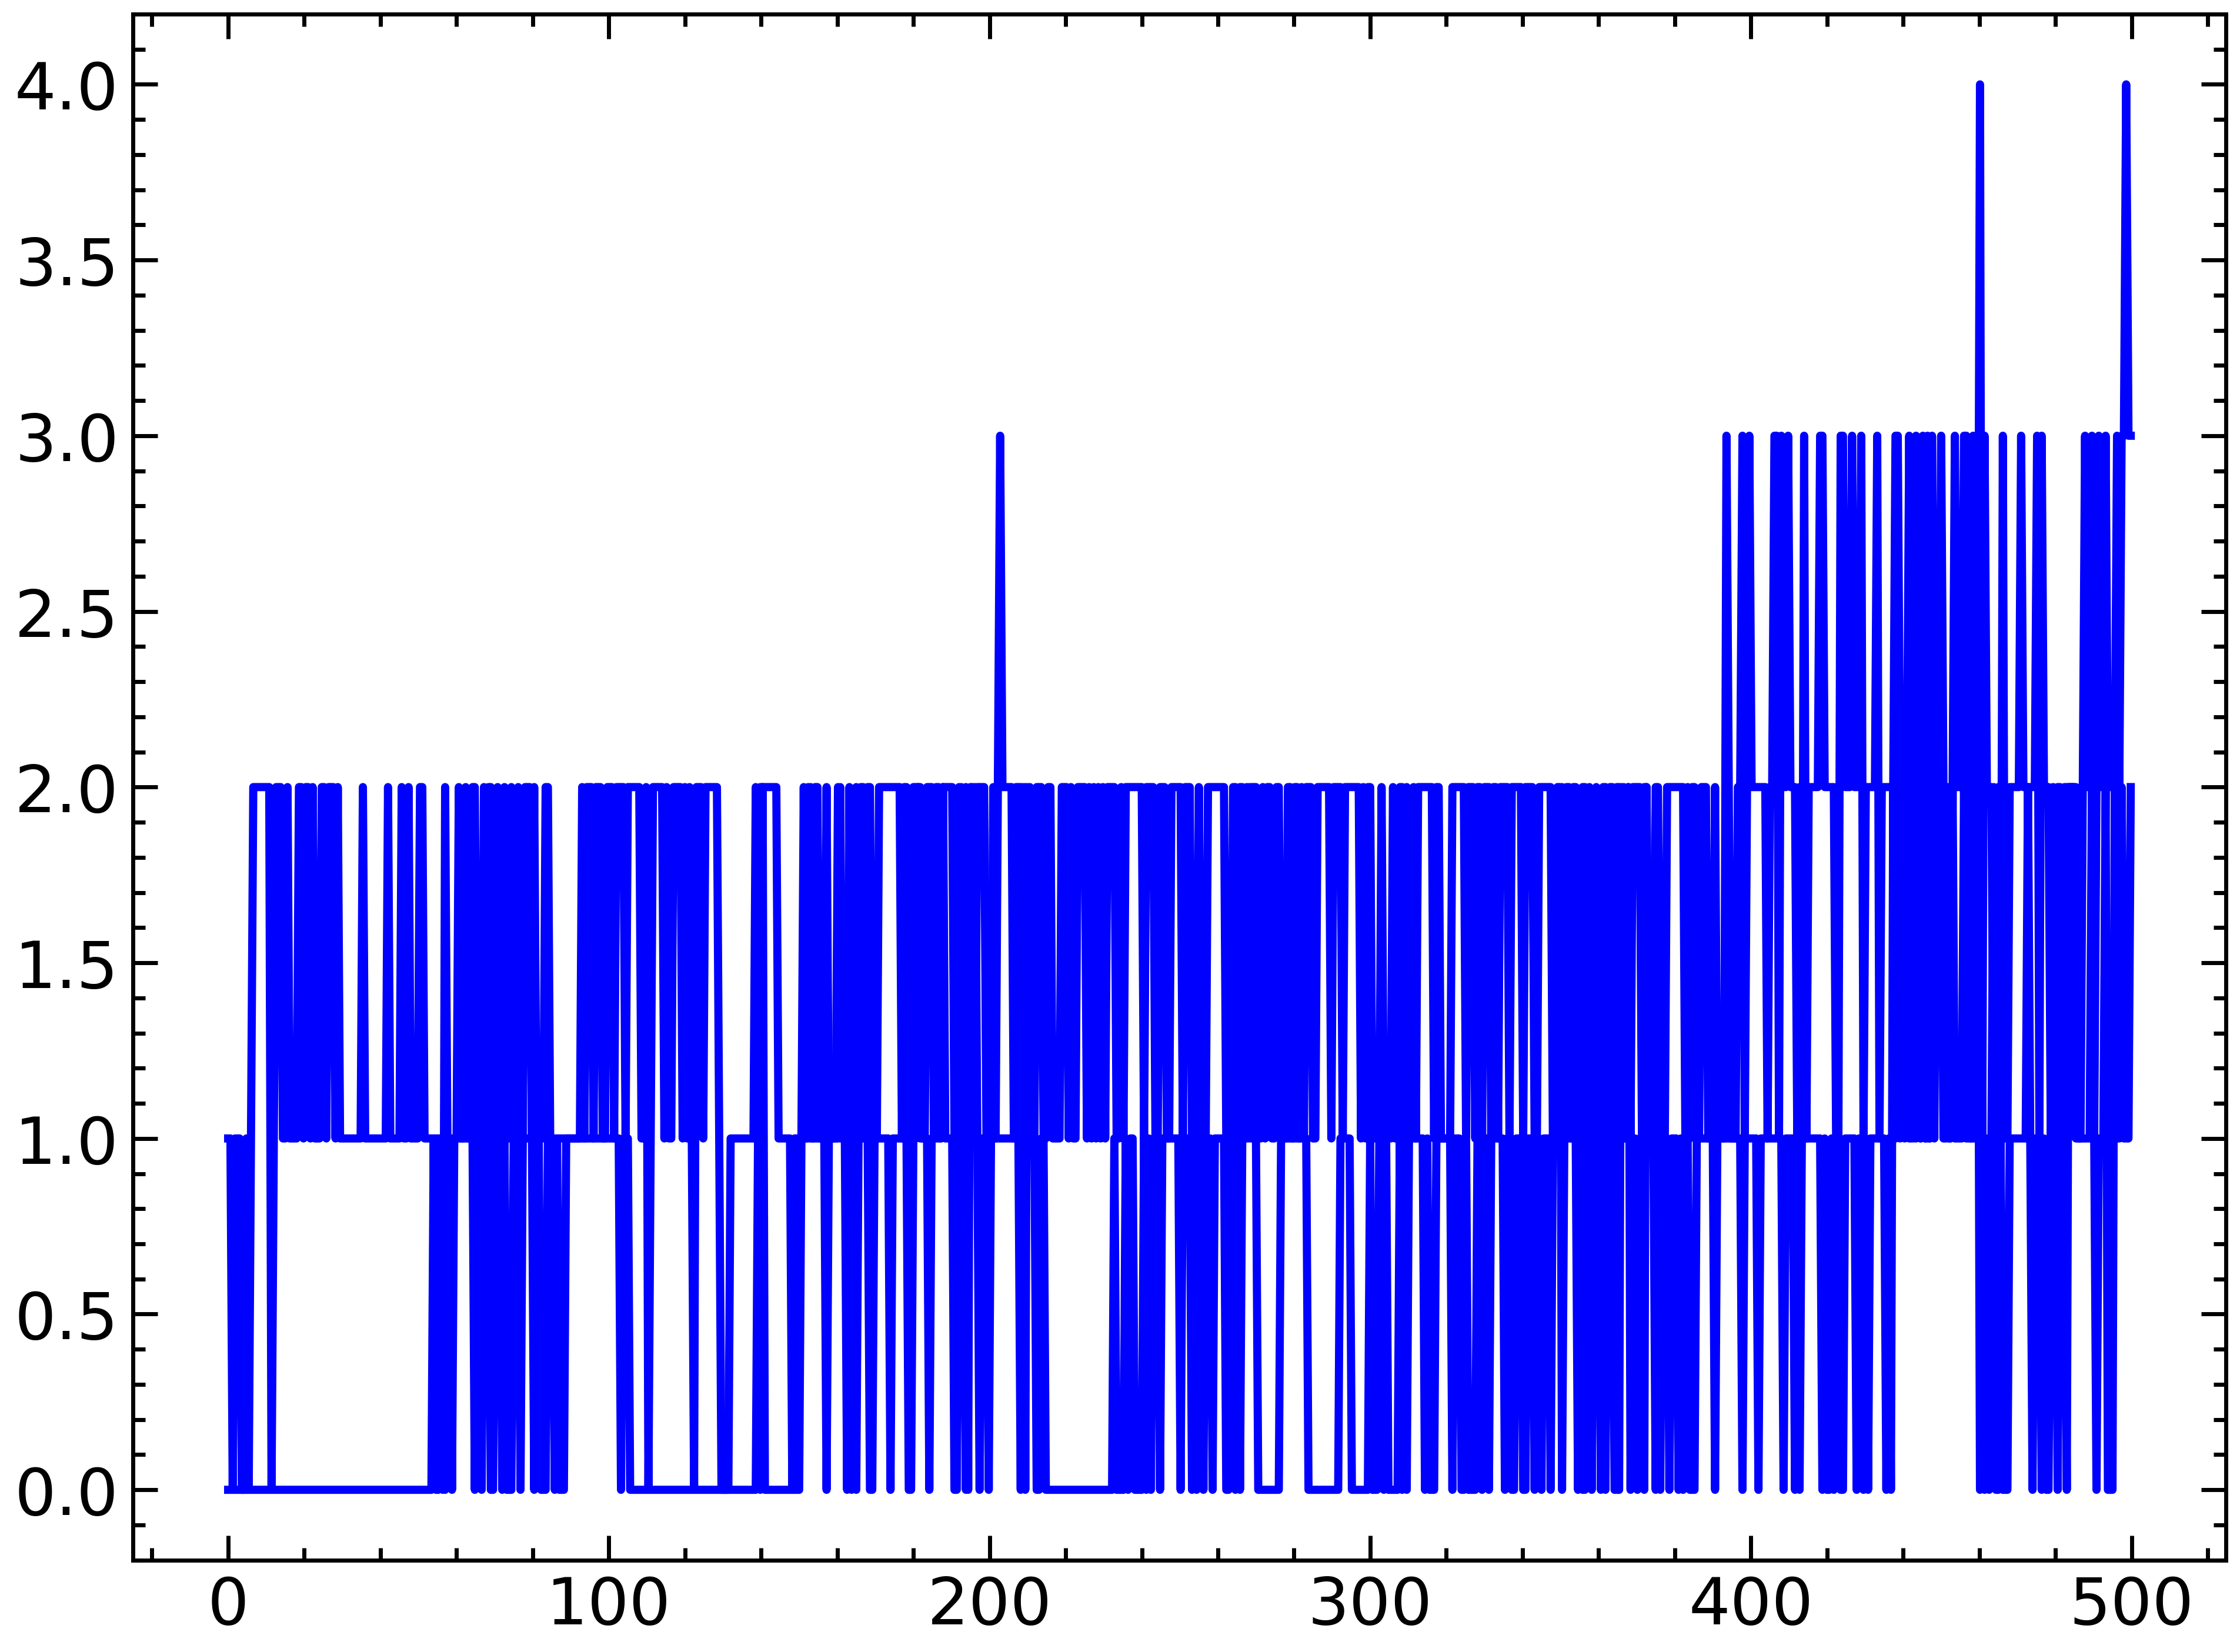

In [22]:
plt.plot(full_traj_run1.time/1000, num_hbonds_run1,'b-')
plt.plot(full_traj_run2.time/1000, num_hbonds_run2,'b-')


## Plots

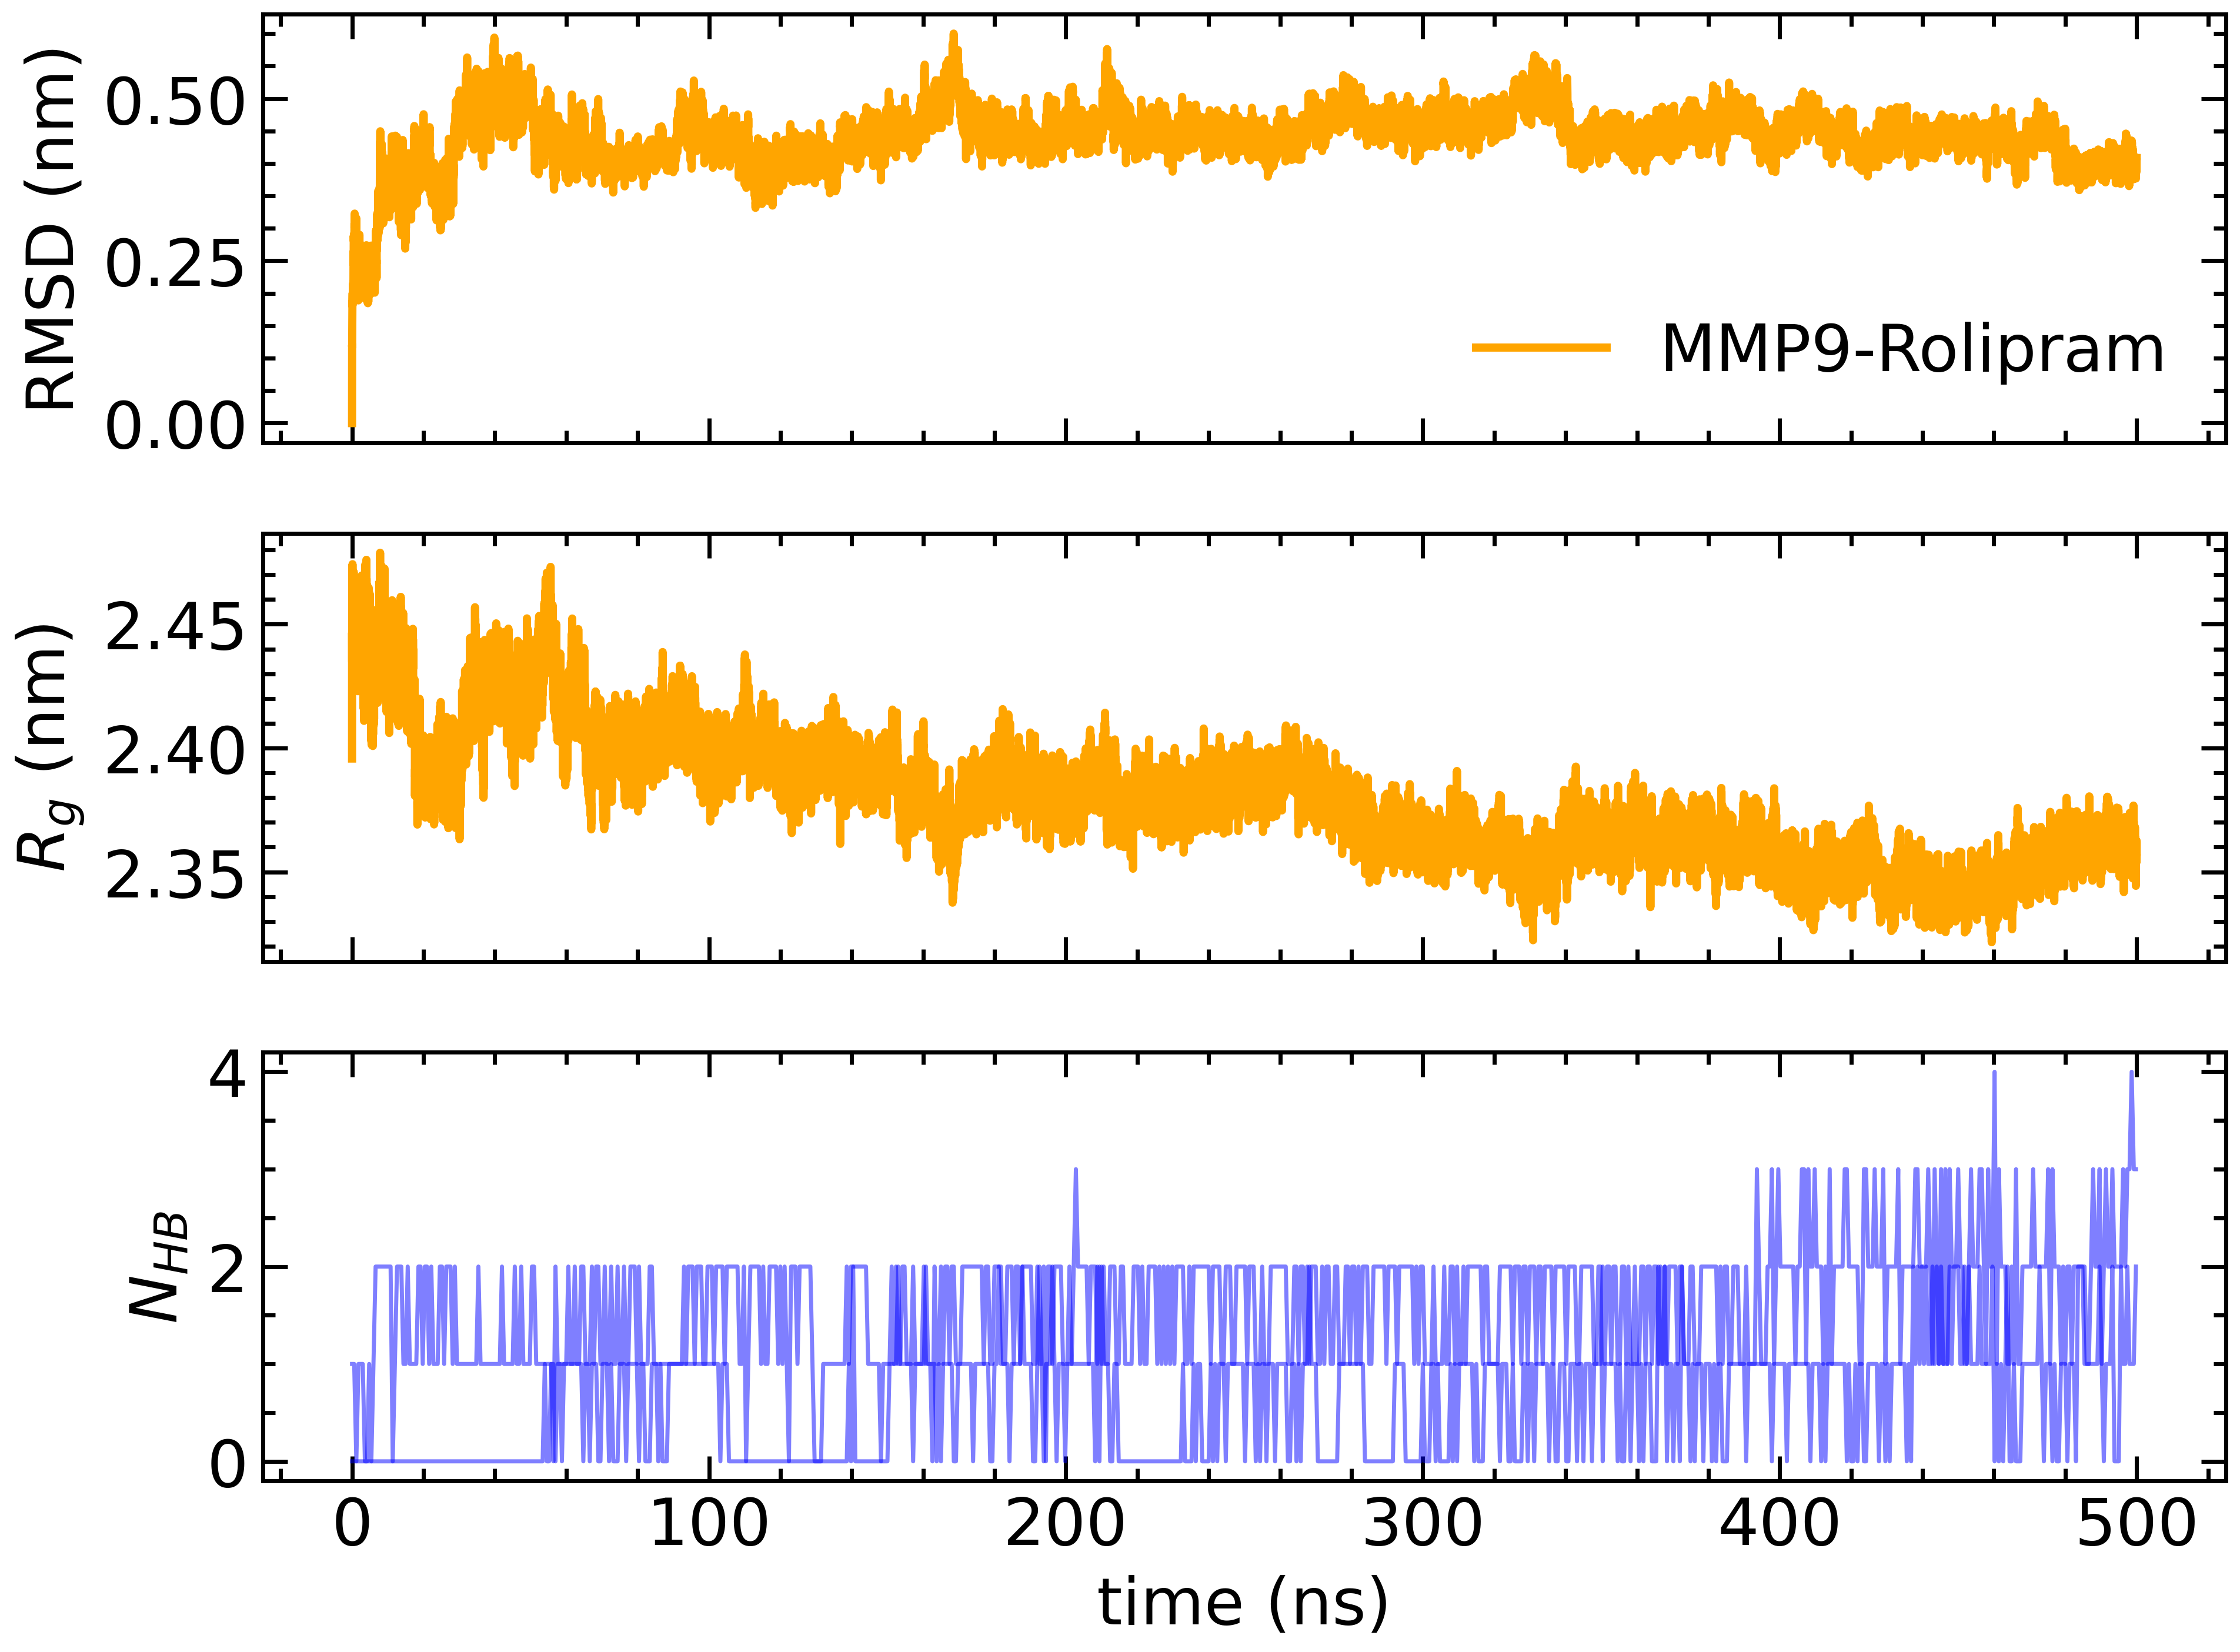

In [23]:
npanels = 3
fig, axs = plt.subplots(npanels,1, sharex=True, tight_layout=True)

ax_rmsd = axs[0]
ax_rmsd.set_ylabel(r'RMSD (nm)');


ax_rmsd.plot(times_c/1000, rmsd_c/10, label="MMP9-Rolipram", 
        color='orange')

ax_rmsd.legend()

ax_rg = axs[1]

ax_rg.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10, 
        label="MMP9-SB3CT", color='orange')
ax_rg.set_ylabel(r'$R_g$ (nm)');

ax_bonds = axs[2]
ax_bonds.set_xlabel(r'time (ns)');

ax_bonds.plot(timestep * np.arange(nframes), num_hbonds_run1, lw=1, label="MMP9-Rolipram", alpha=0.5,color='blue')
ax_bonds.plot(timestep * np.arange(nframes), num_hbonds_run2, lw=1, label="MMP9-Rolipram", alpha=0.5,color='blue')


ax_bonds.set_ylabel(r"$N_{HB}$")
#plt.savefig("time-series-plots.png", dpi=600)
plt.show()

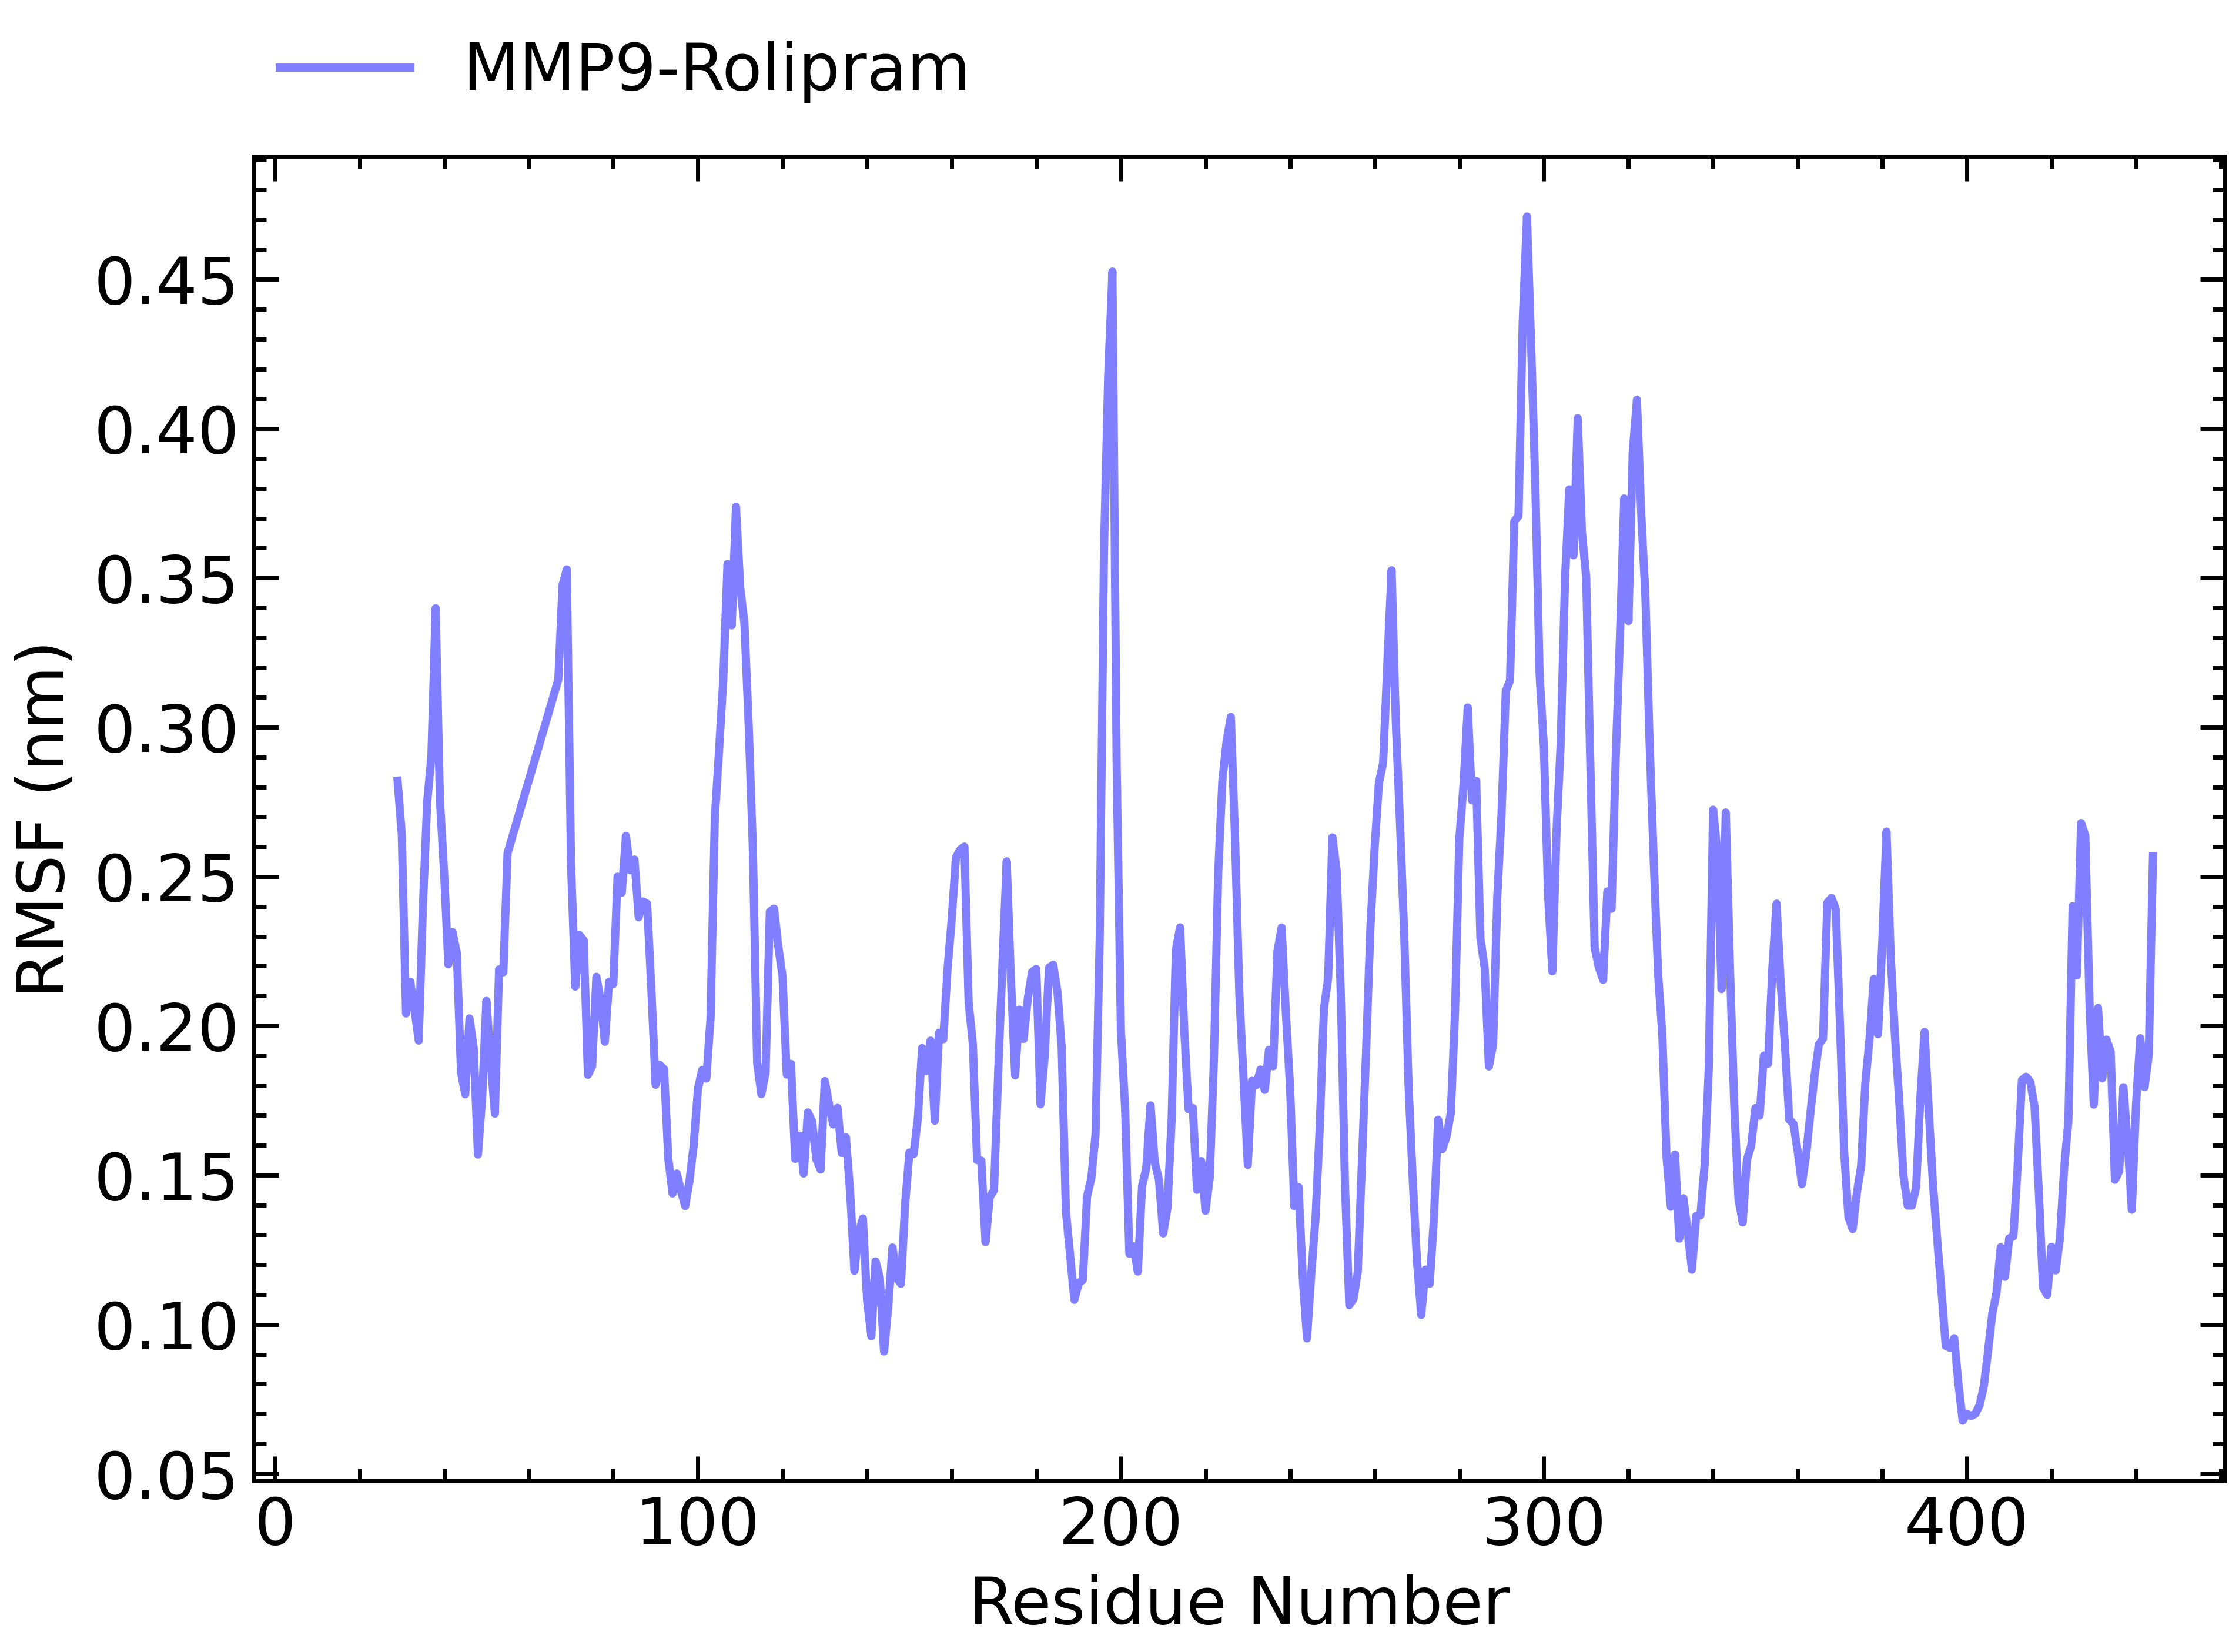

In [24]:
import matplotlib.pyplot as plt

line_c, = plt.plot(c_alphas_c_resids, R_c_results_rmsf/10, label="MMP9-Rolipram", 
                alpha=0.5, color="blue")

plt.xlabel('Residue Number')
plt.ylabel('RMSF (nm)')
plt.xlim(-5, 461)
#ax1.set_ylim(-0.02, 0.45)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncols=2, mode="expand", borderaxespad=0.);

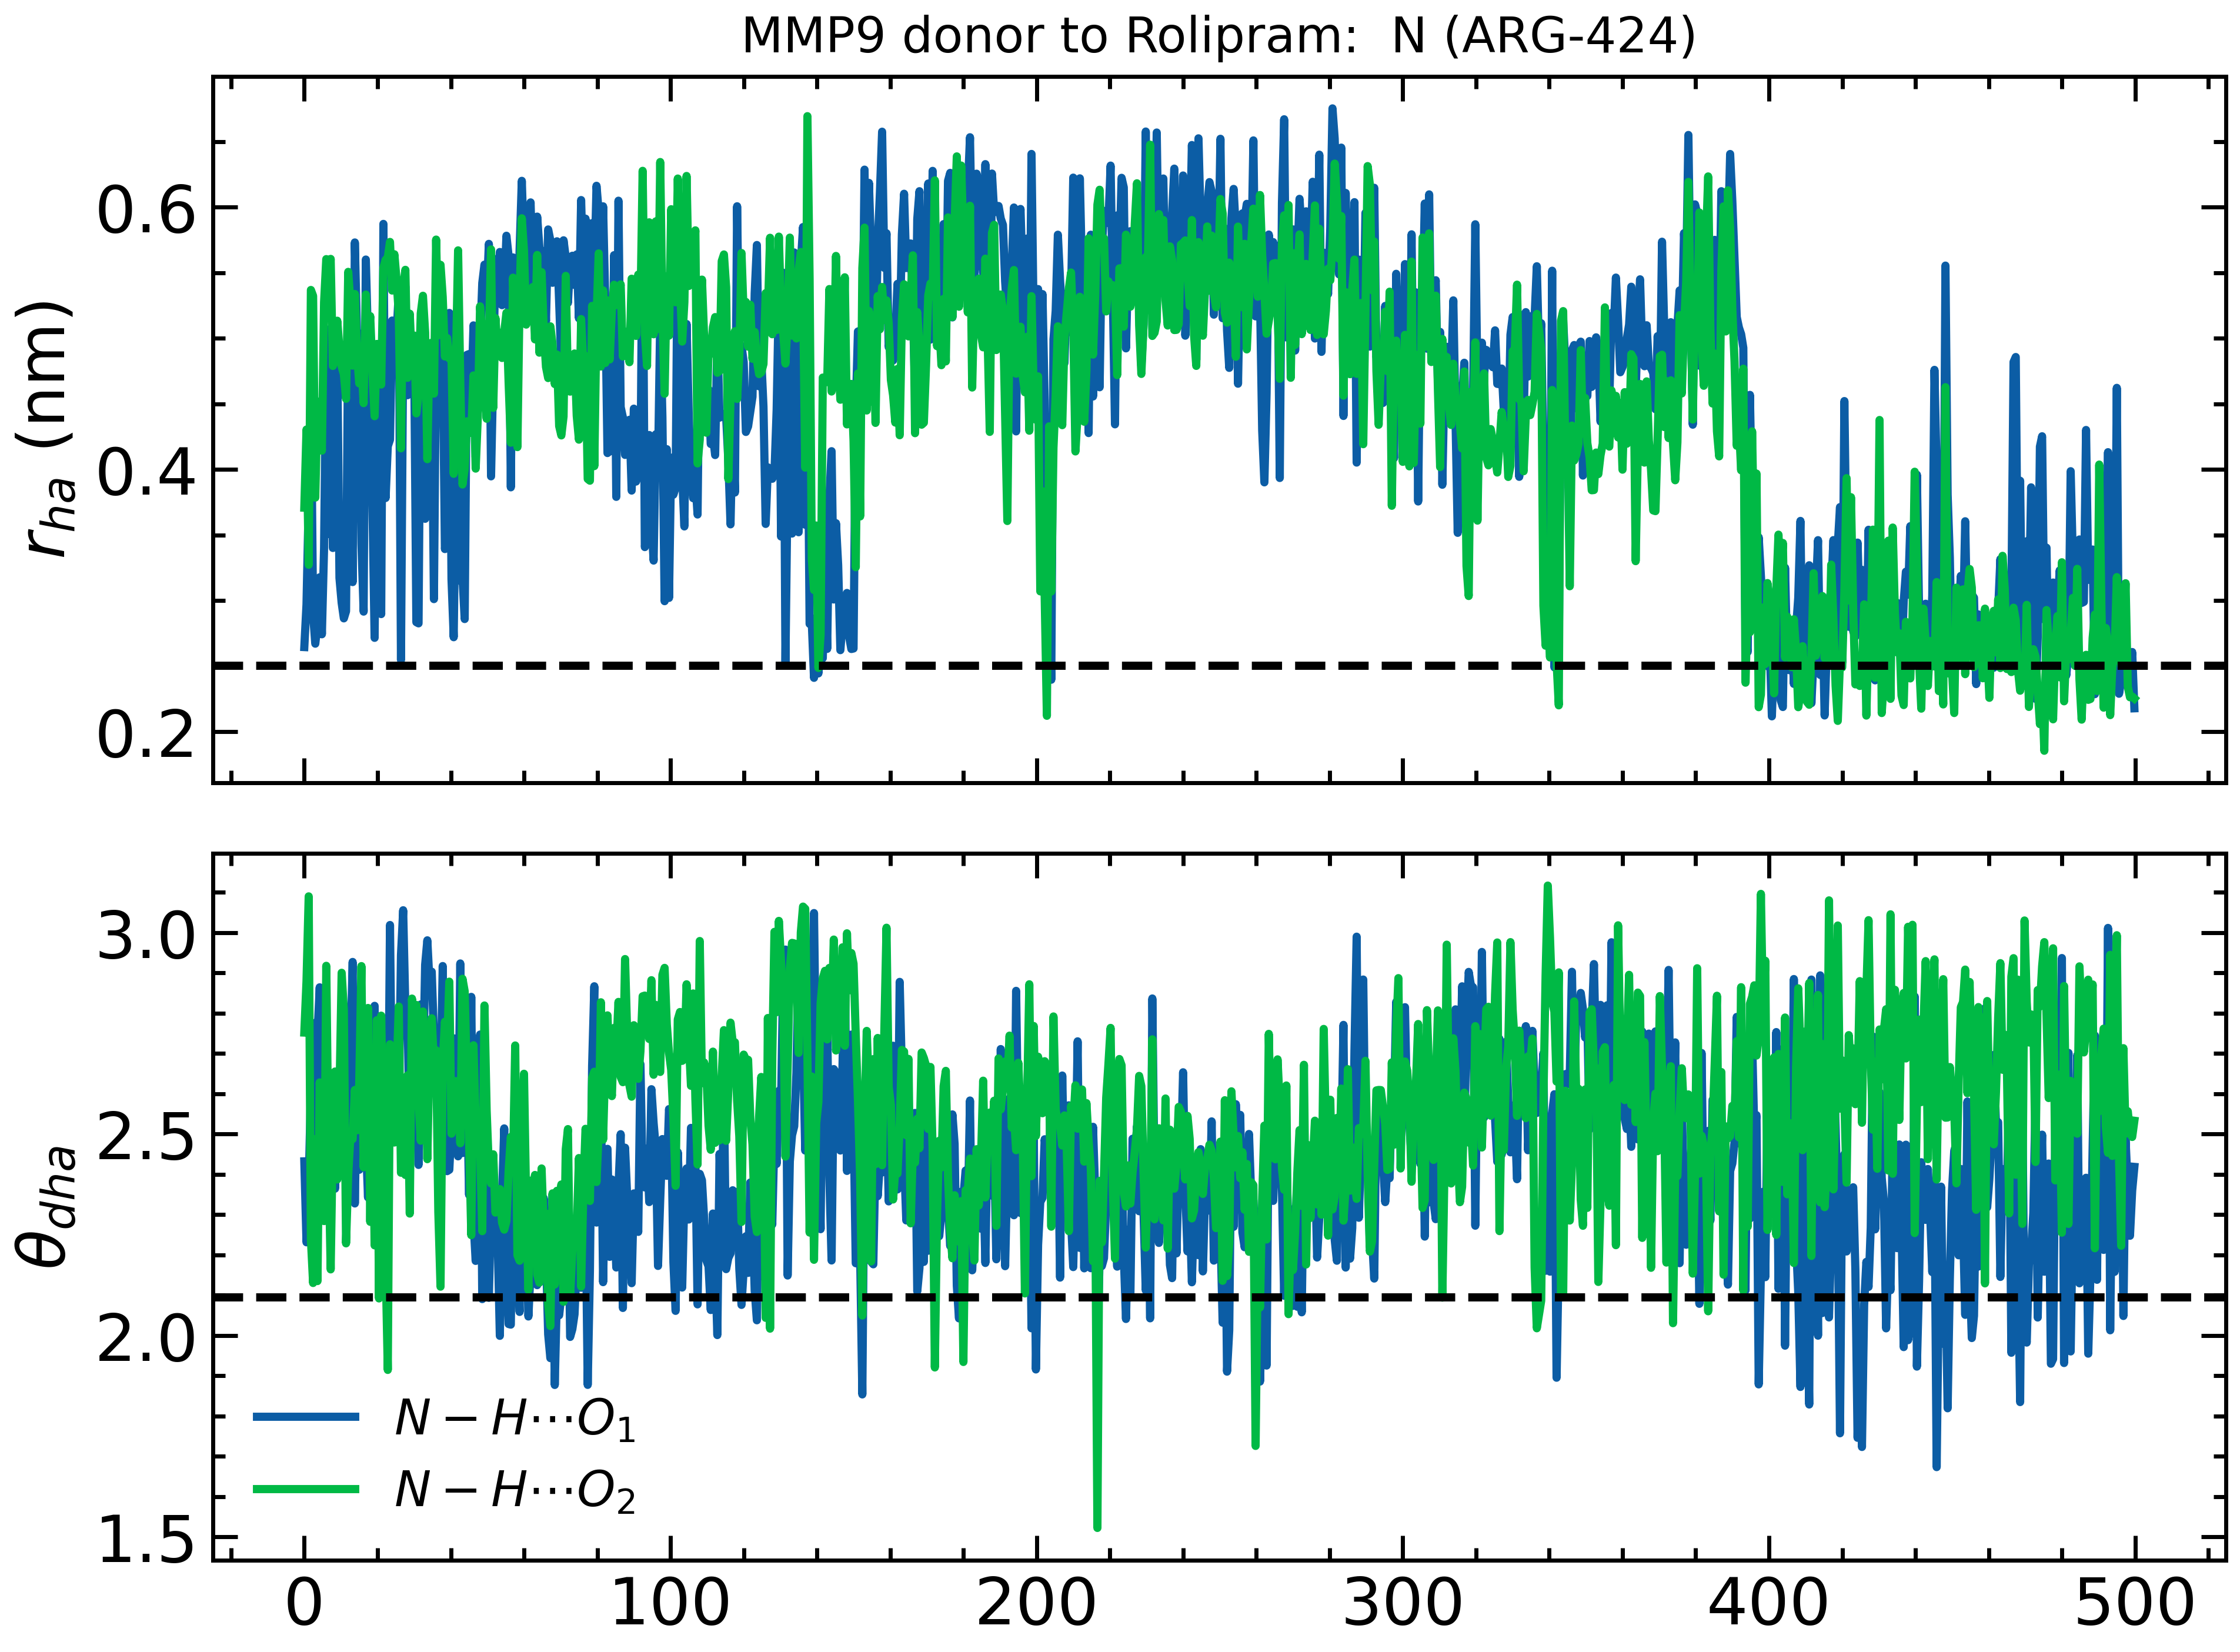

In [52]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, tight_layout=True)
nframes, n_hbonds = da_distances_run1.shape


ax0.set_title('MMP9 donor to Rolipram:  N (ARG-424)', fontsize=12)
ax0.plot(timestep * np.arange(nframes), da_distances_run1[:,-2], label=r'$N-H\cdots O_1$')
ax0.plot(timestep * np.arange(nframes), da_distances_run1[:,-1], label=r'$N-H\cdots O_2$')
ax0.set_ylabel(r'$r_{ha}$ (nm)')

ax0.axhline(0.25, color='black', linestyle='--')

nframes, n_hbonds = da_angles_run1.shape

ax1.plot(timestep * np.arange(nframes), da_angles_run1[:,-2],label=r'$N-H\cdots O_1$')
ax1.plot(timestep * np.arange(nframes), da_angles_run1[:,-1],label=r'$N-H\cdots O_2$')
ax1.set_ylabel(r'$\theta_{dha}$')


ax1.legend(fontsize=12)
ax1.axhline(2*np.pi/3, color='black', linestyle='--')

As can be seen from the above analysis, there is basically just two hbonds (probably the same one shifting from one residue to the adjacent one) being consistently detected, namely, $N (424-ARG)-H\cdots O_{1,2}$.  I'm presently ignoring the other hbonds detected by `MDTraj` since neither of them are common to both runs.

## Principal Component Analysis

We will do the PCA two ways: First using `MDAnslysis`, then using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`, as seen below.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.

### PCA using MDAnalysis
Following the PCA HOWTO in the [MDAnalysis userguide](https://userguide.mdanalysis.org/stable/examples/analysis/reduced_dimensions/pca.html)

***Update*** I removed this analysis in 20241229, as it was too slow, even with parallel processing, and yielded quantitatively poor results gompared to `gromacs`.

### PCA via GROMACS tools

Firt, create an index for backbone, ligand and zinc

`gmx make_ndx -f md500.gro -o md500_pca.ndx` Choose backbone OR LIG OR ZN2

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

`gmx trjconv -s md.tpr -f md500_compact_compact.xtc -o start.pdb -dump 0`

Selections should be the index just created.

Then, generating the eigenvectors

`gmx covar -s start.pdb -f md_center.xtc -o eigenvalues.xvg -v eigenvectors.trr -xpma covapic.xpm -n md500_pca.ndx`
Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1 and pc2 files

`gmx anaeig -f md500_compact_compact.xtc -s start.pdb -v eigenvectors.trr -last 1 -proj pc1.xvg -n md500_pca.ndx`

`gmx anaeig -f md500_compact_compact.xtc -s start.pdb -v eigenvectors.trr -first 2 -last 2 -proj pc2.xvg -n md500_pca.ndx`

Use these two xvg files (pc1.xvg and pc2.xvg) to generate the following plots.

In [2]:
import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = 'pc1.xvg'
pc2_file = 'pc2.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format

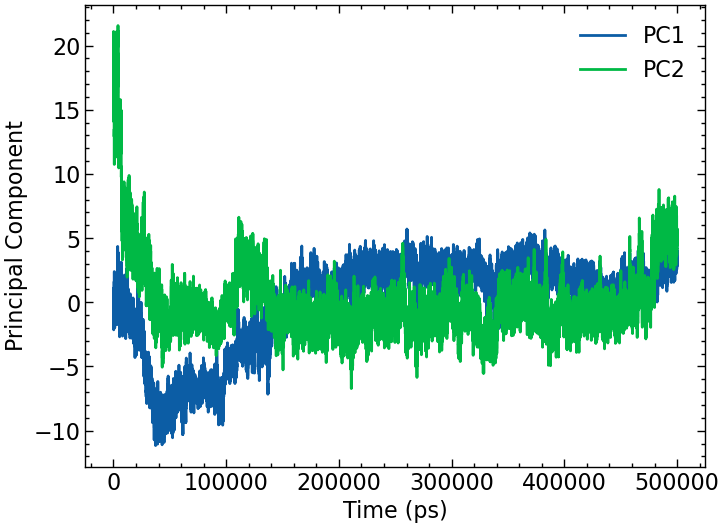

In [3]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.plot(t1, pc1_data, label='PC1')
plt.plot(t2, pc2_data, label='PC2')
plt.xlabel('Time (ps)')
plt.ylabel('Principal Component')
plt.legend()

For PCA with respect to energy, first

`paste pc1.xvg pc2.xvg | awk '{print $1, $2, $4}' > PC1PC2.xvg`

Then, use this PC1PC2.xvg file to generate an xpm file

`gmx sham -f PC1PC2.xvg -ls FES.xpm`

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

`./xpm2txt.py -f FES.xpm -o FEL.dat`

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = 'FEL.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC1 = data[:, 0]
PC2 = data[:, 1]
free_energy = data[:, 2]


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    xpoints = data[:, 0]
    ypoints = data[:, 1]
    return xpoints, ypoints

# Replace these placeholders with your actual file paths
D1_path = 'eigenvalues_1.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)


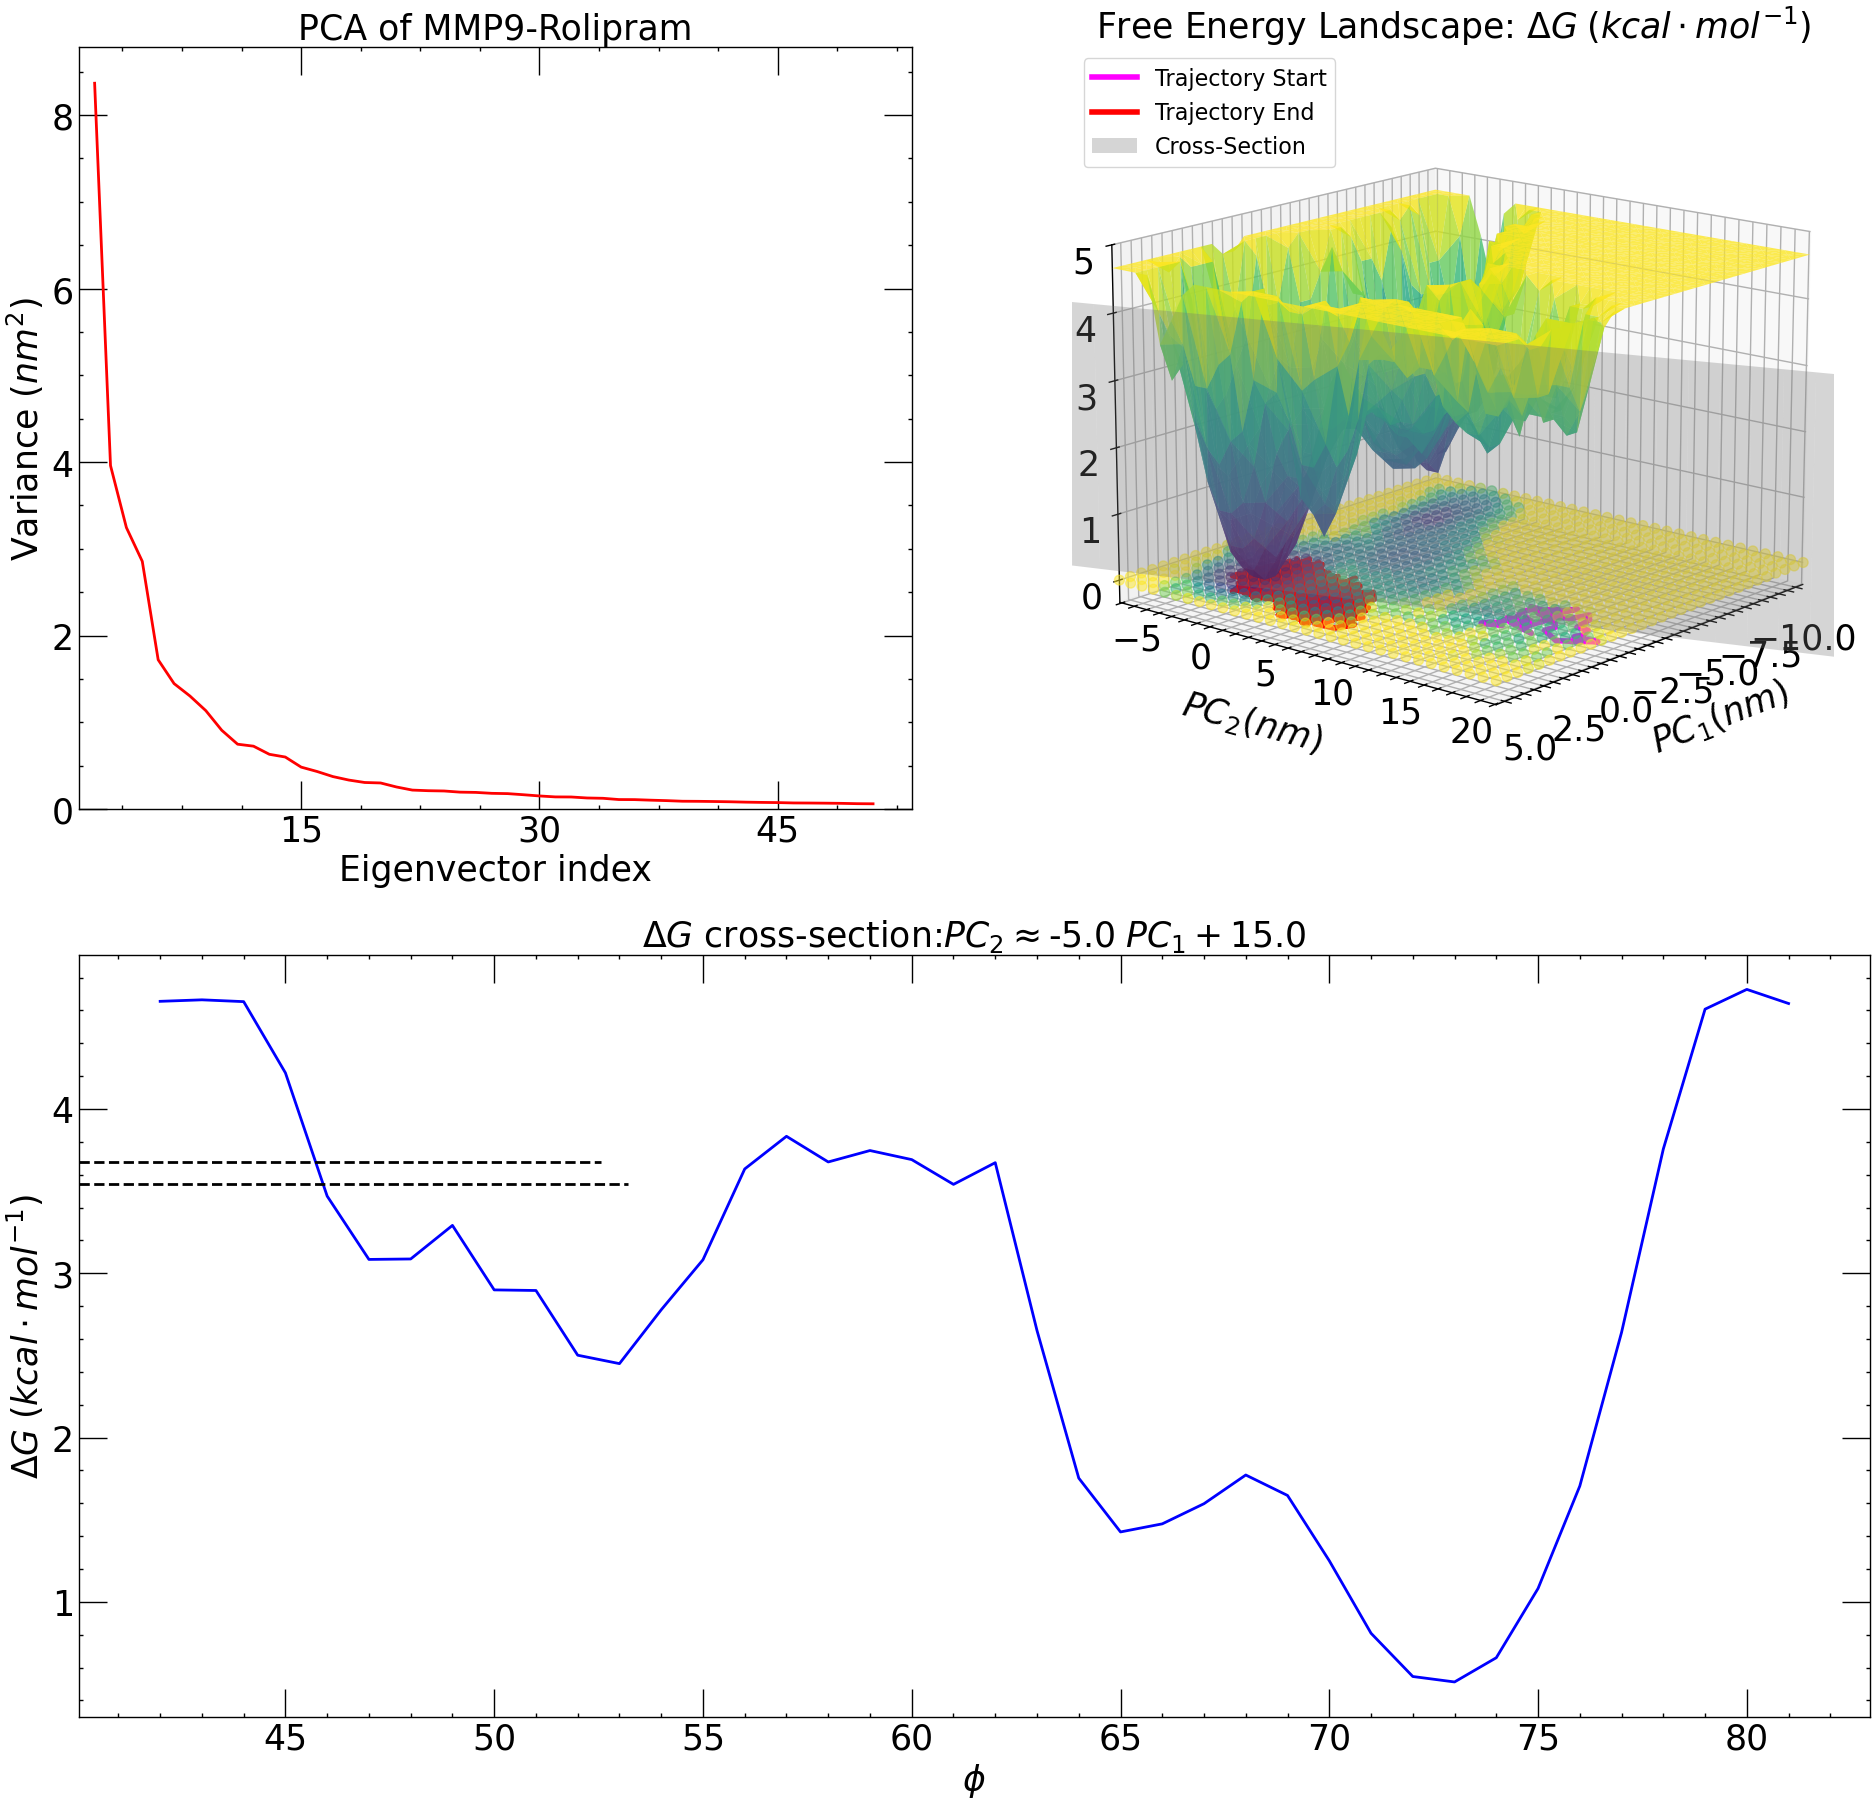

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scienceplots
from scipy.interpolate import griddata
from scipy.signal import argrelextrema

import matplotlib.pyplot as plt

plt.style.use(['science','notebook'])

#########################################################################################
# Adjust this to pinpoint the delta G cross-section at the line along the PC1-PC2 plane you want to analyze 
x1, y1 = 0, 15
x2, y2 = 3, 0
# Calculate the slope (m) and intercept (b) of the line passing through p1 and p2
m = (y2 - y1)/(x2 - x1)
b = y1 - m * x1
# The cross section is along y = m * x + b

# Adjust this to set the initial guess for the minima search
trial_minima = [7, 30]
#########################################################################################

# Create a figure with 3 panels
fig = plt.figure(tight_layout=True, figsize=(35, 35))

# Upper left panel: Eigenvalue cumulative sum plot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(time_D1[0:50], D1_data[0:50], color='red')
ax1.set_xlim(1, )
ax1.set_ylim(0, )
ax1.set_xlabel('Eigenvector index')
ax1.set_ylabel(r'Variance $\left(nm^2\right)$')
ax1.set_title('PCA of MMP9-Rolipram')
ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.tick_params(axis='both', which='major')

# Upper right panel: 3D plot of the free energy
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.plot_trisurf(PC1, PC2, free_energy/4.184, cmap='viridis', alpha=0.8)
ax2.zaxis.set_rotate_label(False)  # disable automatic rotation
ax2.set_xlabel(r'$PC_1\left(nm\right)$', labelpad=25)
ax2.xaxis.set_tick_params(pad=10)
ax2.set_ylabel(r'$PC_2\left(nm\right)$', labelpad=20)
ax2.yaxis.set_tick_params(pad=0)
ax2.set_title(r'Free Energy Landscape: $\Delta G\; \left(kcal \cdot mol^{-1}\right)$')
ax2.scatter(PC1, PC2, c=free_energy/4.184, cmap='viridis', s=50, alpha=0.5)
ax2.plot(pc1_data[0:50], pc2_data[0:50], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax2.plot(pc1_data[-5000:-1], pc2_data[-5000:-1], 0, color='red', linewidth=4, label='Trajectory End')

#Plot the cross-section
x = np.linspace(np.min(PC1), np.max(PC1), 100)
# Create a meshgrid for the plane
X, Z = np.meshgrid(x, np.linspace(0, 4, 2))
Y = m * X + b
# Plot the plane
ax2.plot_surface(X, Y, Z, color='gray', alpha=0.3, label='Cross-Section')
ax2.set_xlim(np.min(PC1), np.max(PC1))
ax2.set_ylim(np.min(PC2), np.max(PC2))
ax2.view_init(elev=15, azim=40)
ax2.legend()

# Lower panel: Cross-section plot with fitting and all points
ax3 = fig.add_subplot(2, 1, 2)
ax3.set_title(r'$\Delta G$ cross-section:' + r'$PC_2 \approx $' + f'{np.round(m)}' + r'$\;PC_1+$' + f'{np.round(b)}')



# Obtain the cross-section of the interpolant along the x-axis
x_cross_section = np.linspace(min(PC2), max(PC2), 200)
y_plot = griddata((PC1, PC2), free_energy / 4.184,\
        (x_cross_section, m * x_cross_section + b), method='cubic')

x_plot = np.arange(0, len(x_cross_section))
# Plot the cross-section values in ax3
ax3.plot(x_plot, y_plot, color='blue')
ax3.set_xlabel(r'$\phi$')
ax3.set_ylabel(r'$\Delta G\;(kcal\cdot mol^{-1})$')


# Find local minima
minima_indices = argrelextrema(y_plot, np.less)[0]
minima_x = x_plot[minima_indices]
minima_y = y_plot[minima_indices]

chosen_minima_idx = [2,3]

# Plot horizontal lines and annotate minima
for x, y in zip(minima_x[chosen_minima_idx], minima_y[chosen_minima_idx]):
    xmin = np.min(x_plot)
    xmax = np.max(x_plot)
    ax3.axhline(y=y, xmin=xmin, xmax=(x-xmin)/(xmax-xmin),\
        color='black', linestyle='dashed')
    #ax3.text(np.min(x_plot)+0.1, y, f'{y:.2f}', color='black',\
    #    verticalalignment='bottom', horizontalalignment='right', fontsize=25)

fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax2.set_position([0.55, 0.55, 0.8, 0.8])  # [left, bottom, width, height]

# Make all mark sizes bigger
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', length=20)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.xaxis.label.set_size(25)
    ax.yaxis.label.set_size(25)
    ax.title.set_size(25)
    if hasattr(ax, 'zaxis'):
        ax.zaxis.label.set_size(25)
        ax.zaxis.set_tick_params(labelsize=25)
ax2.legend(frameon=True, loc="upper left")
#plt.savefig('free_energy_landscape.png', dpi=300)
# Show the plot
plt.show()

### PCA Conclusion

The `gromacs` way is quantitatively better, although both `gromacs` and `MDAnalysis` yield similar qualitative landscapes. I'm inclined to prefer the `gromacs` data as there are clearly fewer truncation errors in while selecting the first two principal axes compared to `MDAnalysis`.


### Some Physics

The trajectory starts from the metastable minimum (magenta), which was in the neighbourhood of the docked configuration, whose free energy was determined during the docking run. Thus, **this metastable minimum in Free Energy is that local minimum in Energy where the docking wound up**. The trajectory then clearly wants to go to the global minimum at the end (red).

In deference to Landau Theory, we plot the cross-section of $\Delta G$ along the cross-section line (obtained by trial and error) and fit it to a symmetry-broken double well
\begin{equation*}
\Delta G(x) = g_0 + a(\phi-\phi_0)^2 + b(\phi-\phi_0)^4 + h(\phi-\phi_0),
\end{equation*}
where $\phi$ is the linear combination of $PC_1, PC_2$ co-ordinates that lies on the cross-section line.The stationary points where $\Delta^\prime G(\phi) = h + 2a(\phi-\phi_0) + 4b(\phi-\phi_0)^3$ vanishes (marked in blue) correspond to the extrema points. The upper extremum is near the docked pose where the trajectory starts. The value of $\Delta G\approx 3.16\; kcal\cdot mol^{-1}$. The lower extremum is where the trajectory ends up, with $\Delta G \approx 0.83 \; kcal\cdot mol^{-1}$. Thus, a rough estimate of the change in free energy as the system transitions from the metastable docked pose to the final equilibrium configuration is $\Delta G \approx 0.83 - 3.16 = -2.33 \; kcal\cdot mol^{-1}$. The initial affinity at the docked pose was $=-10.11 \; kcal\cdot mol^{-1}$, according to `AMDock`, so the final affinity is $\Delta G \approx -10.11-2.33 = -12.44\; kcal\cdot mol^{-1}$, pretty close to the `SB3CT` case.
